In [2]:
import os
import sys
import importlib

import pandas as pd
import numpy as np
import sklearn.model_selection as sel
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import seaborn as sb

from sklearn import svm


# add project modules to the path
path_to_module = os.path.abspath(os.path.join(os.getcwd(),"..","src/"))
sys.path.append(path_to_module)

import src.models.train_model as train

I'm now repeating code a lot here, bad! Will need to write bits of this

In [3]:
path_to_data = os.path.abspath(os.path.join(os.getcwd(),
                                            "..",
                                            "data/processed/"
                                           ))

data_dict = train.load_processed_data(file_path=path_to_data)

loading files from /home/edd/Documents/Projects/minst-ensemble/data/processed: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


In [4]:
X = data_dict["X_train"]
y = data_dict["y_train"]

In [5]:
X_train, X_test, y_train, y_test = sel.train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

In [6]:
X_train_smol, X_test_smol, y_train_smol, y_test_smol = sel.train_test_split(X,
                                                    y,
                                                    test_size=0.09,
                                                    train_size=0.21,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

In [9]:
et_clf = ensemble.ExtraTreesClassifier(  random_state=42,
                                         verbose=True)

In [10]:
et_params = {"n_estimators": [100,200,500,1000,1500],
            }

In [11]:
grid_search = sel.GridSearchCV(estimator=et_clf, 
                               param_grid=et_params,
                               scoring = "f1_macro",
                               n_jobs = 2,
                               cv=3,
                               verbose = 10
                              )

In [12]:
grid_search.fit(X_train_smol, y_train_smol)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   27.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  5.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=True, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'n_estimators': [100, 20

In [13]:
grid_search.best_params_

{'n_estimators': 1500}

In [14]:
grid_search.best_score_

0.9360979007484489

the biggest model is bestest.

In [16]:
et_results_df = pd.DataFrame(grid_search.cv_results_)

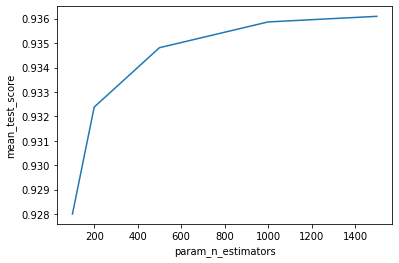

In [17]:
sb.lineplot(x="param_n_estimators", y="mean_test_score",data=et_results_df)

Extra trees appear to outperform random forest, so this means our data is noisey and the greedy approach that random forests take to feature selection for fitting the trees is not working as well as a random search.

We also get relatively more improvement as we increase size than random forest models.

lets try looking at these around 1000


In [18]:
et_params = {"n_estimators": [x for x in range(800,1250,50)],
            }

In [19]:
grid_search = sel.GridSearchCV(estimator=et_clf, 
                               param_grid=et_params,
                               scoring = "f1_macro",
                               n_jobs = 2,
                               cv=3,
                               verbose = 10
                              )

In [20]:
grid_search.fit(X_train_smol, y_train_smol)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 16.1min
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 21.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=True, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'n_estimators': [800, 85

In [23]:
et_results_df = pd.DataFrame(grid_search.cv_results_)

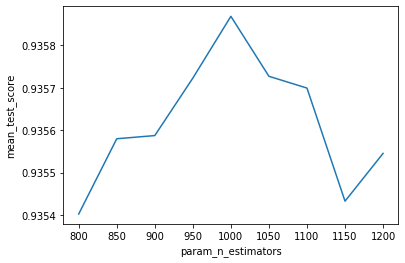

In [25]:
sb.lineplot(x="param_n_estimators", y="mean_test_score",data=et_results_df)

looks like noise mostly. Will stick with around 800

In [34]:
et_params = {"n_estimators": [600,700,800,900,1000],
             "criterion": ["gini", "entropy"]
            }

In [35]:
grid_search = sel.GridSearchCV(estimator=et_clf, 
                               param_grid=et_params,
                               scoring = "f1_macro",
                               n_jobs = 2,
                               cv=3,
                               verbose = 10
                              )

In [37]:
grid_search.fit(X_train_smol, y_train_smol)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 13.2min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 20.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=True, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'criterion': ['gini', 'e

In [39]:
grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 1000}

In [40]:
grid_search.best_score_

0.935868594993987

In [41]:
et_results_df = pd.DataFrame(grid_search.cv_results_)

In [42]:
et_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,48.600141,0.629846,3.948871,0.025436,gini,600,"{'criterion': 'gini', 'n_estimators': 600}",0.934426,0.936967,0.933631,0.935008,0.001422,10
1,56.752305,0.696792,4.694367,0.032092,gini,700,"{'criterion': 'gini', 'n_estimators': 700}",0.935549,0.937131,0.934075,0.935585,0.001248,4
2,64.791797,1.168119,5.361460,0.020246,gini,800,"{'criterion': 'gini', 'n_estimators': 800}",0.935327,0.937010,0.933870,0.935402,0.001283,7
3,74.418961,0.654995,6.030512,0.028293,gini,900,"{'criterion': 'gini', 'n_estimators': 900}",0.935521,0.937400,0.933840,0.935587,0.001454,3
4,81.520224,2.657915,6.661952,0.062958,gini,1000,"{'criterion': 'gini', 'n_estimators': 1000}",0.935994,0.937792,0.933819,0.935869,0.001624,1
5,60.982500,0.672891,3.836027,0.013571,entropy,600,"{'criterion': 'entropy', 'n_estimators': 600}",0.935396,0.937201,0.933083,0.935227,0.001685,9
6,69.243536,0.376446,4.458302,0.009407,entropy,700,"{'criterion': 'entropy', 'n_estimators': 700}",0.935862,0.937221,0.932749,0.935278,0.001872,8
7,78.966424,0.213082,5.087245,0.024794,entropy,800,"{'criterion': 'entropy', 'n_estimators': 800}",0.935856,0.937652,0.933044,0.935517,0.001896,5
8,88.706592,0.150331,5.724556,0.018736,entropy,900,"{'criterion': 'entropy', 'n_estimators': 900}",0.936059,0.937562,0.933366,0.935663,0.001736,2
9,105.419931,4.870804,7.115691,1.477155,entropy,1000,"{'criterion': 'entropy', 'n_estimators': 1000}",0.935643,0.937251,0.933647,0.935514,0.001474,6


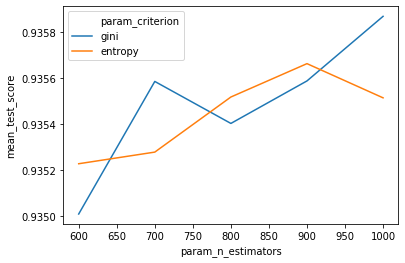

In [44]:
sb.lineplot(x="param_n_estimators", 
            y="mean_test_score",
            hue = "param_criterion",
            data=et_results_df)

not really any difference, we go with gini as it is less computationally intensive

In [10]:
et_features_params = {"n_estimators": [600,700,800,900,1000],
             "criterion": ["gini"],
             "max_features": ["auto", "sqrt", "log2", None]
            }



In [11]:
grid_search = sel.GridSearchCV(estimator=et_clf, 
                               param_grid=et_features_params,
                               scoring = "f1_macro",
                               n_jobs = 2,
                               cv=3,
                               verbose = 10
                              )

In [12]:
grid_search.fit(X_train_smol, y_train_smol)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   54.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 12.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 16.5min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 21.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 28.9min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 53.8min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 63.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=True, warm_start=False),
             iid='warn', n_jobs=2,
             param_grid={'criterion': ['gini'],
 

In [13]:
grid_search.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000}

In [14]:
grid_search.best_score_

0.935868594993987

not making any changes, looks like we top out at 0.936ish. Bit better than random forests, nearly as good as the KNN, but not as good as the SVMs
